In [9]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from prettytable import PrettyTable

# Database functions

In [63]:
user_name = os.environ.get('DB_USER')
password = os.environ.get('DB_PASSWORD')

DB_NAME = 'BacterialGrowth'

def execute(phrase):
    """This function create a connection to the database and execute a command.
    :param phrase: str SQL sentence to execute
    :return: list of str received from the database after command execution.
    """
    try:
        cnx = mysql.connector.connect(user=user_name, password=password,host='localhost',database=DB_NAME)
        cnx.get_warnings = True
        cursor = cnx.cursor()
        cursor.execute(phrase)
        res = []
        for row in cursor:
            res.append(row)

        warnings = cursor.fetchwarnings()
        if warnings: 
            for i in range(len(warnings)):
                print("\t ** Warning - "+warnings[i][2])
        cursor.close()
        cnx.commit()
        cnx.close()
        return res
    except mysql.connector.Error as err:
        print("Something went wrong: {}".format(err))
        print(phrase)

def addRecord(table, args):
    """ 
    This function adds a new entry into the indicated table.

    :table: table of the DB
    :args: dictionary with the data to insert
    :return: id of the inserted record
    """
    # Insert into table
    fields, values = getFieldsValues(args)
    phrase = "INSERT IGNORE INTO " +table+" "+fields+" VALUES "+values
    res = execute(phrase)
    
    # Get the name of the primary key field
    phrase = "SHOW KEYS FROM "+table+" WHERE Key_name = 'PRIMARY'"
    res = execute(phrase)
    pk = res[0][4]
    
    # Get the value of the primary key (this will return the value both if it was inserted or ignored)
    where_clause = getWhereClause(args)
    phrase = "SELECT "+pk+" FROM "+table+" "+where_clause
    res = execute(phrase)
    last_id = res[0][0]
    
    return last_id

def countRecords(table, args):
    phrase = "SELECT COUNT(*) FROM " + table
    if args:
        where_clause = getWhereClause(args)
        phrase = phrase+" "+where_clause
    res = execute(phrase)
    return res

def getAllRecords(table, **args):
    phrase = "SELECT * FROM " + table
    if args:
        where_clause = getWhereClause(args)
        phrase = phrase+" "+where_clause
    res = execute(phrase)
    return res

def getFiles(field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM TechnicalReplicate "+where_clause
    res = execute(phrase)
    return res

def getRecords(table, field, args):
    where_clause = getWhereClause(args)
    phrase = "SELECT "+field+" FROM "+table+" "+where_clause
    res = execute(phrase)
    return res

# Utils functions

In [40]:
def isDir(string):
    '''
    This function checks if the given string is a directory path
    '''
    if os.path.isdir(string):
        return string
    else:
        raise NotADirectoryError(string)
    
def isFile(string):
    '''
    This function checks if the given string is a directory path
    '''
    if os.path.isfile(string):
        return string
    else:
        a = 0
        # Put warning or something here

def findOccurrences(string, ch):
    '''
    This function returns a list with all the positions of the string that contain the character ch
    '''
    return [i for i, letter in enumerate(string) if letter == ch]


def getMatchingList (regex, lst):
    '''
    This function takes a regex expression and returns a list with all the matching words in the given lst
    '''
    res = []
    for word in lst:
        if regex.findall(word):
            res.append(word)
    return res

def saveFile(data, path):
    if len(data.columns) > 1:
        data.to_csv(path, sep=" ", index=False)


def getIntersectionColumns(df, columns):
    res = df[df.columns.intersection(columns)]
    return res

def getFieldsValues(args):
    fields = "("
    values = "("
    for key, val in args.items():
        fields = fields + key + ','
        values = values + "'" +str(val) + "',"
    fields = fields[:-1] + ')'
    values = values[:-1] + ')'
    return [fields, values]

def getWhereClause(args):
    clause = "WHERE ("
    for key, val in args.items():
        if val != 'null':
            clause = clause + key + "= '" + str(val) + "' AND "
        if val == 'null':
            clause = clause + key + " IS NULL AND "
    clause = clause[:-5] + ')'
    return clause
    
def getMeanStd(records, header):
    df = pd.DataFrame(columns=range(len(records)+1)) #Each column will be the value of each record
    # Fill the df parsing all the records' files
    for i, record in enumerate(records, 1):
        record_df = pd.read_csv(record[0], sep=" ")
        df.iloc[:,i] = record_df[header]

    # Calculate and keep mean and std
    df_res = pd.DataFrame(columns=range(3))
    df_res.set_axis(['time', 'mean', 'std'], axis='columns', inplace=True)
    df_res['time'] = record_df['time']
    df_res['mean'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
    df_res['std'] = df.iloc[:,1:].std(axis=1, numeric_only=True)
    
    return df_res


# Functions

In [7]:
def chooseStudy():
    studies = getAllRecords('Study')

    if len(studies) == 0:
        print('\n\tERROR: There are no studies yet in the DB')
        print('\t- Create an study using the flag -s.\n')
        exit()
    
    studies_table = PrettyTable()
    studies_table.field_names = ["ID", "Name", "Description"]
    studies_table.align["Name"] = "l"
    studies_table.align["Description"] = "l"

    studies_id = []
    for study in studies:
        studies_table.add_row(study)
        studies_id.append(str(study[0]))
    
    print(studies_table)

    study_id = input("-- Choose study ID: ")
    if study_id not in studies_id:
        print('\n\tERROR: You have not selected a valid study ID. Check the table above.\n')
        exit()
    
    return study_id

def chooseExperiment(study_id):
    experiments = getAllRecords('Experiment', studyId=study_id)
     
    if len(experiments) == 0:
        print('\n\tERROR: There are no experiments with id {}:'.format(study_id))
        print('\t- Select another study ID\n\t- Create experiments with this study ID before introducing perturbations/replicates files into it.\n')
        exit()

    experiments_table = PrettyTable()
    experiments_table.field_names = ["ID","Name","Study ID","Precult","Reactor","Plate ID","Column","Row","Media","Blank","inoculumConc","inoculumVol","initPh","initTemp","carbonSource","antibiotic","Description"]
    
    experiments_id = []
    for experiment in experiments:
        experiments_table.add_row(experiment)
        experiments_id.append(str(experiment[0]))
    
    print(experiments_table)    

    experiment_id = input("-- Choose experiment ID: ")
    if experiment_id not in experiments_id:
        print('\n\tERROR: You have not selected a valid experiment ID. Check the table above.\n')
        exit()

    return experiment_id

def choosePerturbation(experiment_id):
    perturbations = getAllRecords('Perturbation', experimentId=experiment_id)

    if len(perturbations) == 0:
        print('\n\tERROR: There are no perturbations with experiment id {}:'.format(experiment_id))
        print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
        exit()

    perturbations_table = PrettyTable()
    perturbations_table.field_names = ["ID","Experiment ID","Property","New Value","Starting time (min)","Ending time (min)","Description"]
    
    perturbations_id = []
    for perturbation in perturbations:
        perturbations_table.add_row(perturbation)
        perturbations_id.append(str(perturbation[0]))
    
    print(perturbations_table)    

    perturbation_id = input("-- Choose perturbation ID: ")
    if perturbation_id not in perturbations_id:
        print('\n\tERROR: You have not selected a valid perturbation ID. Check the table above.\n')
        exit()

    return perturbation_id

def chooseReplicate(experiment_id, perturbation_id):
    if perturbation_id == None:
        id = experiment_id
        replicates = getAllRecords('TechnicalReplicate', experimentId=id)
        if len(replicates) == 0:
            print('\n\tERROR: There are no replicates with experiment_id {}'.format(id))
            print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
            exit()

    else:
        id = perturbation_id
        replicates = getAllRecords('TechnicalReplicate', perturbationId=id)
        if len(replicates) == 0:
            print('\n\tERROR: There are no replicates with perturbation_id {}'.format(id))
            print('\t- Select another experiment ID\n\t- Create perturbation with this experiment ID before introducing replicates files into it.\n')
            exit()

    replicates_table = PrettyTable()
    replicates_table.field_names = ["ID","Experiment ID","Perturbation ID"]
    
    replicates_id = []
    for replicate in replicates:
        print(replicate[0:3])
        replicates_table.add_row(replicate[0:3])
        replicates_id.append(str(replicate[0]))
    
    print(replicates_table)    

    replicate_id = input("-- Choose replicate ID: ")
    if replicate_id not in replicates_id:
        print('\n\tERROR: You have not selected a valid replicate ID. Check the table above.\n')
        exit()

    return replicate_id

# User input to get the args

In [15]:
print('Choose the plotting option:')
print('\t1: Plot one technical replicate.') #OK
print('\t2: Plot mean and deviation from several replicates from the same perturbation.')
print('\t3: Plot mean and deviation from several replicates from the same experiment.')
print('\t4: Plot mean and deviation from several replicates from one experiment (with all its perturbations).')

Choose the plotting option:
	1: Plot one technical replicate.
	2: Plot mean and deviation from several replicates from the same perturbation.
	3: Plot mean and deviation from several replicates from the same experiment.
	4: Plot mean and deviation from several replicates from one experiment (with all its perturbations).


In [18]:
option = 3

In [14]:
if option == 1:
    study_id = chooseStudy()
    experiment_id = chooseExperiment(study_id)
    perturbation_id = choosePerturbation(experiment_id)
    replicate_id = chooseReplicate(experiment_id=experiment_id, perturbation_id=perturbation_id)
    
    args = {'replicateId': replicate_id}
    
    print(args)

+----+--------+-------------+
| ID | Name   | Description |
+----+--------+-------------+
| 1  | quiron | None        |
| 2  | Casa   | None        |
+----+--------+-------------+
-- Choose study ID: 1
+-----+--------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
|  ID |  Name  | Study ID | Precult | Reactor | Plate ID | Column | Row | Media | Blank | inoculumConc | inoculumVol | initPh | initTemp | carbonSource | antibiotic | Description |
+-----+--------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
| 101 | Prueba |    1     |   None  |    1    |    1     |   1    |  A  |   1   |   0   |      1       |      1      |  1.0   |   1.0    |      0       |     0      |     None    |
+-----+--------+----------+---------+---------+----------+--------+-----+-

In [17]:
if option == 2:
    study_id = chooseStudy()
    experiment_id = chooseExperiment(study_id)
    perturbation_id = choosePerturbation(experiment_id)
    
    args = {'perturbationId': perturbation_id}
    
    print(args)

+----+--------+-------------+
| ID | Name   | Description |
+----+--------+-------------+
| 1  | quiron | None        |
| 2  | Casa   | None        |
+----+--------+-------------+
-- Choose study ID: 1
+-----+--------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
|  ID |  Name  | Study ID | Precult | Reactor | Plate ID | Column | Row | Media | Blank | inoculumConc | inoculumVol | initPh | initTemp | carbonSource | antibiotic | Description |
+-----+--------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
| 101 | Prueba |    1     |   None  |    1    |    1     |   1    |  A  |   1   |   0   |      1       |      1      |  1.0   |   1.0    |      0       |     0      |     None    |
+-----+--------+----------+---------+---------+----------+--------+-----+-

If arguments refer to an experimentId there are two options which are automatically differentiated, the user does not need to indicate it:
* If the experiment has **no perturbations** (len(perturbation_ids)==0) it will plot separate or msd (depending on the values option) of the replicates of that experiment (**EXAMPLE: {'experimentId': '103'}**)
* If the experiment has **1 perturbation**

In [20]:
if option == 3:
    study_id = chooseStudy()
    experiment_id = chooseExperiment(study_id)
    
    args = {'experimentId': experiment_id}
    
    print(args)
    

+----+--------+-------------+
| ID | Name   | Description |
+----+--------+-------------+
| 1  | quiron | None        |
| 2  | Casa   | None        |
+----+--------+-------------+
-- Choose study ID: 1
+-----+--------------------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
|  ID |        Name        | Study ID | Precult | Reactor | Plate ID | Column | Row | Media | Blank | inoculumConc | inoculumVol | initPh | initTemp | carbonSource | antibiotic | Description |
+-----+--------------------+----------+---------+---------+----------+--------+-----+-------+-------+--------------+-------------+--------+----------+--------------+------------+-------------+
| 101 |       Prueba       |    1     |   None  |    1    |    1     |   1    |  A  |   1   |   0   |      1       |      1      |  1.0   |   1.0    |      0       |     0      |     None    |
| 102 | NewFilesExperiment

In [141]:
def getMeanStd(files, regex=''):
    '''
    This function gets a df and the columns (regex or all columns) in which mean and std are going to be calculated
    For each header, 
    '''
    df = pd.read_csv(files[0][0], sep=" ")
    
    if regex != '':
        headers = getMatchingList(regex, df)
    else:
        headers = df.columns
    
    msd = pd.DataFrame(columns=range(1))
    msd.set_axis(['time'], axis='columns', inplace=True)
    msd['time'] = df['time']
    
    for header in headers:
        if header != 'time':
            df_header = pd.DataFrame(columns=range(len(files)+1)) #Each column will be the value from each file

            # Fill the df parsing all the records' files
            for i, file in enumerate(files, 1):
                file_df = pd.read_csv(file[0], sep=" ")
                df_header.iloc[:,i] = file_df[header]

            # Calculate and keep mean and std
            msd_header = pd.DataFrame(columns=range(3))
            msd_header.set_axis(['time', header+'_mean', header+'_std'], axis='columns', inplace=True)
            msd_header['time'] = file_df['time']
            msd_header[header+'_mean'] = df_header.iloc[:,1:].mean(axis=1, numeric_only=True)
            msd_header[header+'_std'] = df_header.iloc[:,1:].std(axis=1, numeric_only=True)

            msd = pd.merge(msd, msd_header, on='time')
    
    return msd

In [140]:
def plotDf(df, ax):
    cmap = plt.get_cmap(name='tab10')
    msd_regex = re.compile(r'.*mean.* | .*std.*', flags=re.I | re.X)
    
    if len(getMatchingList(msd_regex, df)) > 0:
        vec = range(1,len(df.columns),2)
        for i in vec:
            ax.errorbar(df.iloc[:,0], df.iloc[:,i], yerr = df.iloc[:,i+1], color = cmap(i-1), label=df.columns[i][:-5])
    else:
        vec = range(1,len(df.columns))
        for i in vec:
            ax.plot(df.iloc[:,0], df.iloc[:,i], linestyle='-', color = cmap(i-1), label=df.columns[i])

In [134]:
abundance_options = ['od', 'counts', 'qpcr', 'rnaseq']
od_regex = re.compile(r'.*time.* | .*OD.*', flags=re.I | re.X)
counts_regex = re.compile(r'.*time.* | .*count.*', flags=re.I | re.X)
qpcr_regex = re.compile(r'.*time.* | .*qpcr.*', flags=re.I | re.X)
rnaseq_regex = re.compile(r'.*time.* | .*rna.*', flags=re.I | re.X)

def plotAbundances(files, plot_option, args):
    #files = getFiles('abundanceFile', args)

    if len(files) == 1:
        
        df = pd.read_csv(files[0][0], sep=" ")
        for opt in abundance_options:
            regex = globals()['%s_regex' % opt]
            headers = getMatchingList(regex, df)
            data = getIntersectionColumns(df, headers)
            
            # plot
            fig = plt.figure()
            ax = fig.add_subplot()
            if len(data.columns)>1: plotDf(data, ax)
            else: plt.close()
            plt.show()
            
    # If args is not replicateId => we have several replicates
    elif len(files) > 1:
        experimentFiles = checkExperimentHasPerturbations(args['experimentId'])
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        if len(perturbation_ids) <= 1:
            for opt in abundance_options:
                regex = globals()['%s_regex' % opt]
                
                fig = plt.figure()
                ax = fig.add_subplot()
                plotPerturbation(files, plot_option, regex, len(perturbation_ids), ax)
                plt.show()
        
        # Poner que si hay más de una perturbación o 
        # 1 experimento + sus perturbaciones, que lo separe también
        elif len(perturbation_ids) > 1:
            for opt in abundance_options:
                regex = globals()['%s_regex' % opt]
                
                fig = plt.figure()
                ax = fig.add_subplot()

                for pert_id in perturbation_ids:
                    args = {'perturbationId': pert_id[0]}
                    pert_files = getFiles('abundanceFile', args)
                    plotPerturbation(pert_files, plot_option, regex, len(perturbation_ids), ax)

                plt.show()


In [139]:
def plotPerturbation(files, regex, ax):
    for file in files:         
        data = getMeanStd(files, regex=regex)
        
        if len(data.columns)>1: plotDf(data, ax)
        else: plt.close()

In [142]:
def checkExperimentHasPerturbations(args):
    
    args_null = {'experimentId': args['experimentId']}
    exp_with_null = countRecords('TechnicalReplicate', args_null)[0][0]
    print('Exp with null values: ', exp_with_null)
    
    args_no_null = {'experimentId': args['experimentId'], 'perturbationId': 'null'}
    exp_without_null = countRecords('TechnicalReplicate', args_no_null)[0][0]
    print('Exp without null values: ', exp_without_null)
    
    if exp_with_null != exp_without_null and exp_with_null > 0 and exp_without_null > 0:
        experimentFiles = False
        
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        
        fig = plt.figure()
        ax = fig.add_subplot()
        
        for perturbation_id in perturbation_ids:
            files = getFiles('abundanceFile', {'perturbationId': perturbation_id[0]})
            
            plotPerturbation(files, abundance_options, ax)
            plt.show()
            
        print('\n')
        
        args['perturbationId'] = 'null'
        files = getFiles('abundanceFile', args)
        
        plotPerturbation(files, abundance_options, ax)
        
        plt.show()
        
    else:
        experimentFiles = True
        print('We are fine')
        
        perturbation_ids = getRecords('Perturbation', 'perturbationId', args)
        
        if len(perturbation_ids) == 0:
            files = getFiles('abundanceFile', args)
            
            fig = plt.figure()
            ax = fig.add_subplot()
            plotPerturbation(files, abundance_options, ax)
            plt.show()
            
        else:
            for perturbation_id in perturbation_ids:
                files = getFiles('abundanceFile', {'perturbationId': perturbation_id[0]})
                fig = plt.figure()
                ax = fig.add_subplot()
                for file in files:
                    
                    plotPerturbation(files, abundance_options, ax)
                
                plt.show()
        
    return experimentFiles

In [143]:
args = {'experimentId': '101'}

Exp with null values:  18
Exp without null values:  9


AttributeError: 'list' object has no attribute 'findall'

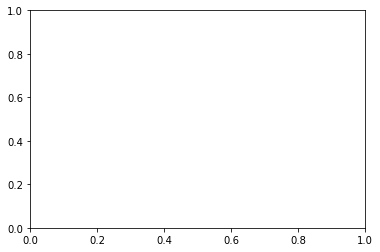

In [144]:
experimentFiles = checkExperimentHasPerturbations(args)

In [ ]:
plotAbundances(files, plot_option, args)